# 環境設定


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import os
soundlist = os.listdir('/content/drive/My Drive/all_data_used')
soundlist

['CuteStrayCat_130.wav',
 'none',
 'caveat',
 'cat_talk_cats',
 'cat_call_persion',
 'purring',
 'x_train_o.npy',
 'y_train_o.npy',
 'x_test_o.npy',
 'y_test_o.npy',
 'used_none_data.npy',
 'to_niose_data.npy']

In [ ]:
pip install pydub librosa

In [ ]:
! pip list

In [ ]:
from keras import backend as K
import gc


K.clear_session()
gc.collect()

Using TensorFlow backend.


22

雜音存成numpy檔

In [ ]:
# from pydub import AudioSegment
# import os
# import numpy as np
# import scipy.io.wavfile as wav
# import random
# import librosa
# import gc
# to_niose_data =[]
# file_name = os.listdir(f"{path}/none")
# data_temp = [f"{path}/none/{item}" for item in os.listdir(f"{path}/none") if item not in used_none_data ]
# for item in data_temp:
#   wave, sr = librosa.load(item, mono=True, sr=None)
#   to_niose_data.append([wave])
# to_niose_data = np.array(to_niose_data)
# np.save(f'{path}/to_niose_data.npy',to_niose_data)

# 讀取npy檔

In [ ]:
from pydub import AudioSegment
import os
import numpy as np
import scipy.io.wavfile as wav
import random
import librosa
import gc
used_none_data = []
path = "/content/drive/My Drive/all_data_used"
x_train_o=np.load(f'{path}/x_train_o.npy',allow_pickle=1)
y_train_o=np.load(f'{path}/y_train_o.npy')
x_test_o=np.load(f'{path}/x_test_o.npy',allow_pickle=1)
y_test_o=np.load(f'{path}/y_test_o.npy')
used_none_data=np.load(f'{path}/used_none_data.npy')
to_niose_data =[x for x in np.load(f'{path}/to_niose_data.npy',allow_pickle=1)]
MFCC_NUM = 20 
SAMPLING_RATE=22050

def wav2mfcc(wave, max_len=512):
#     mfcc = librosa.feature.mfcc(wave, sr=16000)
    wave_mean = abs(np.mean(wave))
    
    if wave_mean != 0:
      wave = wave / wave_mean
    mfcc = librosa.feature.mfcc(wave, n_mfcc=MFCC_NUM, sr=SAMPLING_RATE)

    # If maximum length exceeds mfcc lengths then pad the remaining ones
    if (max_len > mfcc.shape[1]):
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')

    # Else cutoff the remaining parts
    else:
        mfcc = mfcc[:, :max_len]
    
    return mfcc

def wav2stft(wave,max_len=512, n_fft=1024):
    wave_mean = abs(np.mean(wave))
    
    if wave_mean != 0:
      wave = wave / wave_mean
    stft = librosa.feature.chroma_stft(wave, sr=SAMPLING_RATE,n_fft=n_fft )
    ## prepare constant variable
    if (max_len > stft.shape[1]):
        pad_width = max_len - stft.shape[1]
        stft = np.pad(stft, pad_width=((0, 0), (0, pad_width)), mode='constant')

    # Else cutoff the remaining parts
    else:
        stft = stft[:, :max_len]
    return stft



def add_noise(data):
    wn = np.random.normal(0,1,len(data))
    data_noise = np.where(data != 0.0, data.astype('float64') + 0.02 * wn, 0.0)
    return data_noise

def add_noise_other(data, add_path):
#     wn = np.random.normal(0,1,len(data))
    wave, sr = librosa.load(add_path, mono=True, sr=None)
    # wave = librosa.resample(wave, sr, 8000)
    to_num = int(abs(len(data) - len(wave)))
    to_long = np.zeros(to_num).astype('float64')
    if  len(data) > len(wave):
        wave =  np.append(wave,to_long)
    elif len(data) < len(wave):
        data =  np.append(data,to_long)
        
    data_noise = data.astype('float64') + wave
#     data_noise = np.where(data1 != 0.0, data1.astype('float64') + 0.02 * data2, 0.0)
    return data_noise

def add_noise_other_np(data, add_data):
  
    to_num = int(abs(len(data) - len(add_data)))
    to_long = np.zeros(to_num).astype('float64')
    if  len(data) > len(add_data):
        add_data =  np.append(add_data,to_long)
    elif len(data) < len(add_data):
        data =  np.append(data,to_long)
        
    data_noise = data.astype('float64') + (add_data *0.5)

    return data_noise

#  依照檔案路徑存將雜音加入系統中
def GetFataFromPath(data_x,data_y ,add_size=10):
    x = []
    y = []
    global used_none_data
    data_temp = [f"{path}/none/{item}" for item in os.listdir(f"{path}/none") if item not in used_none_data ]
    # data_temp = data_temp[~data_temp==used_none_data]
    data_temp = random.sample(data_temp, add_size)
    for i in range(len(data_x)):
      if i %200 == 0:
        print( i)
      for add_wave in data_temp:
        x_temp = wav2mfcc(add_noise_other(data_x[i][0],add_wave ))
        x.append(x_temp )
        y.append(data_y[i] )
    x = np.array(x)
    x = x.reshape(x.shape[0], x.shape[1], x.shape[2], 1)
    y = np.array(y)

    return x,y

# 依照讀取的檔案加入對應的雜訊
def GetFataFromNp(data_x,data_y ,add_size=10):
    x = []
    y = []
    global used_none_data, to_niose_data
    # data_temp = [f"{path}/none/{item}" for item in os.listdir(f"{path}/none") if item not in used_none_data ]
    # data_temp = data_temp[~data_temp==used_none_data]
    # data_temp = random.sample(list(to_niose_data), add_size)
    data_temp = random.sample(list(to_niose_data), add_size)
    for i in range(len(data_x)):
      if i %200 == 0:
        print( f"now in {i} / {len(data_x)}====>there are {len(y)} data")
        # data_temp = random.sample(list(to_niose_data), add_size)
      x_temp = wav2mfcc(data_x[i][0] )
      x.append(x_temp )
      y.append(data_y[i] )
      # x_temp = wav2mfcc(add_noise(data_x[i][0]))
      # x.append(x_temp )
      # y.append(data_y[i] )
      # data_temp = random.sample(list(to_niose_data), add_size)
      for add_wave in data_temp:
        x_temp = wav2mfcc(add_noise_other_np(data_x[i][0],add_wave[0] ))
        x.append(x_temp )
        y.append(data_y[i] )
    x = np.array(x)
    x = x.reshape(x.shape[0], x.shape[1], x.shape[2], 1)
    y = np.array(y)

    return x,y

In [ ]:
def GetdataFromNp_hstft(data_x,data_y ,add_size=10):
    x = []
    y = []
    x_stft= []
    global used_none_data, to_niose_data
    # data_temp = [f"{path}/none/{item}" for item in os.listdir(f"{path}/none") if item not in used_none_data ]
    # data_temp = data_temp[~data_temp==used_none_data]
    # data_temp = random.sample(list(to_niose_data), add_size)
    data_temp = random.sample(list(to_niose_data), add_size)
    for i in range(len(data_x)):
      if i %200 == 0:
        print( f"now in {i} / {len(data_x)}====>there are {len(y)} data")
        # data_temp = random.sample(list(to_niose_data), add_size)
      x_temp = wav2mfcc(data_x[i][0] )
      x_stft_temp = wav2stft(data_x[i][0] )
      x.append(x_temp )
      x_stft.append(x_stft_temp )
      y.append(data_y[i] )
      # x_temp = wav2mfcc(add_noise(data_x[i][0]))
      # x.append(x_temp )
      # y.append(data_y[i] )
      # data_temp = random.sample(list(to_niose_data), add_size)
      for add_wave in data_temp:
        x_temp = wav2mfcc(add_noise_other_np(data_x[i][0],add_wave[0] ))
        x_stft_temp = wav2stft(add_noise_other_np(data_x[i][0],add_wave[0] ))
        x.append(x_temp )
        x_stft.append(x_stft_temp )
        y.append(data_y[i] )
    x = np.array(x)
    x = x.reshape(x.shape[0], x.shape[1], x.shape[2], 1)
    x_stft = np.array(x_stft)
    x_stft = x_stft.reshape(x_stft.shape[0], x_stft.shape[1], x_stft.shape[2], 1)
    y = np.array(y)

    return x,x_stft,y

In [ ]:
print(len(x_train_o),len(y_train_o),len(x_test_o),len(y_test_o))


1900 1900 100 100


In [ ]:
x_train,y_train =  GetFataFromNp(x_train_o,y_train_o ,add_size=5)
print("==================================")
x_test,y_test =  GetFataFromNp(x_test_o,y_test_o ,add_size=10)

now in 0 / 1900====>there are 0 data
now in 200 / 1900====>there are 1200 data
now in 400 / 1900====>there are 2400 data
now in 600 / 1900====>there are 3600 data
now in 800 / 1900====>there are 4800 data
now in 1000 / 1900====>there are 6000 data
now in 1200 / 1900====>there are 7200 data
now in 1400 / 1900====>there are 8400 data
now in 1600 / 1900====>there are 9600 data
now in 1800 / 1900====>there are 10800 data
now in 0 / 100====>there are 0 data


In [ ]:
x_train1,x_train2,y_train =  GetdataFromNp_hstft(x_train_o,y_train_o ,add_size=5)
print("==================================")
x_test1,x_test2,y_test =  GetdataFromNp_hstft(x_test_o,y_test_o ,add_size=10)

now in 0 / 1900====>there are 0 data


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


now in 200 / 1900====>there are 1200 data
now in 400 / 1900====>there are 2400 data
now in 600 / 1900====>there are 3600 data
now in 800 / 1900====>there are 4800 data
now in 1000 / 1900====>there are 6000 data
now in 1200 / 1900====>there are 7200 data
now in 1400 / 1900====>there are 8400 data
now in 1600 / 1900====>there are 9600 data
now in 1800 / 1900====>there are 10800 data
now in 0 / 100====>there are 0 data


# 前處理檢查 & 儲存成文件


In [ ]:
def show_data(a):
  print(type(a) )
  print(a.shape )
  print(a.dtype )
show_data(x_train)
show_data(x_test)
show_data( y_train)
show_data( y_test)
# print(y_test)
# example.save('example.npy')
# np.save(f'{path}/x_train.npy',x_train)
# np.save(f'{path}/y_train.npy',y_train)
# np.save(f'{path}/x_test.npy',x_test)
# np.save(f'{path}/y_test.npy',y_test)



<class 'numpy.ndarray'>
(11400, 20, 512, 1)
float64
<class 'numpy.ndarray'>
(1100, 20, 512, 1)
float64
<class 'numpy.ndarray'>
(11400, 5)
float64
<class 'numpy.ndarray'>
(1100, 5)
float64


# 讀取聲音文字檔

In [ ]:

# import os
# import numpy as np
# from sklearn.model_selection import train_test_split
# from sklearn.utils import shuffle

# path = "/content/drive/My Drive/all_data_used"
# SAMPLING_RATE = 22050
# MFCC_NUM = 20
# MFCC_MAX_LEN = 1024

# def show_data(a):
#   print(type(a) )
#   print(a.shape )
#   print(a.dtype )


# x_train=np.load(f'{path}/x_train.npy')
# y_train=np.load(f'{path}/y_train.npy')
# x_test=np.load(f'{path}/x_test.npy')
# y_test=np.load(f'{path}/y_test.npy')
# show_data(x_train)
# show_data(x_test)
# show_data( y_train)
# show_data( y_test)



# 資料分割


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

x_train,y_train = shuffle(x_train,y_train) # 打亂測試數據的資料
x_test1,x_test2,y_test1,y_test2=train_test_split(x_test,y_test,test_size=0.5)

def show_data(a):
  print(type(a) )
  print(a.shape )
  print(a.dtype )


show_data(x_test1)
show_data(y_test1)
show_data(x_test2)
show_data(y_test2)
print(y_test1[:5])

<class 'numpy.ndarray'>
(550, 20, 512, 1)
float64
<class 'numpy.ndarray'>
(550, 5)
float64
<class 'numpy.ndarray'>
(550, 20, 512, 1)
float64
<class 'numpy.ndarray'>
(550, 5)
float64
[[0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]]


In [ ]:
# from sklearn.model_selection import train_test_split
# from sklearn.utils import shuffle
# num = shuffle(range(len(x_train1)))

# x_train1 =x_train1[num]
# x_train2 =x_train2[num]
# y_train =y_train[num]

# 建立模組

In [ ]:
from keras import backend as K
import gc

K.clear_session()
gc.collect()

29641

Using TensorFlow backend.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 20, 512, 1)   0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 20, 512, 1)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 18, 510, 32)  320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 18, 510, 32)  320         input_2[0][0]                    
____________________________________________________________________________________________

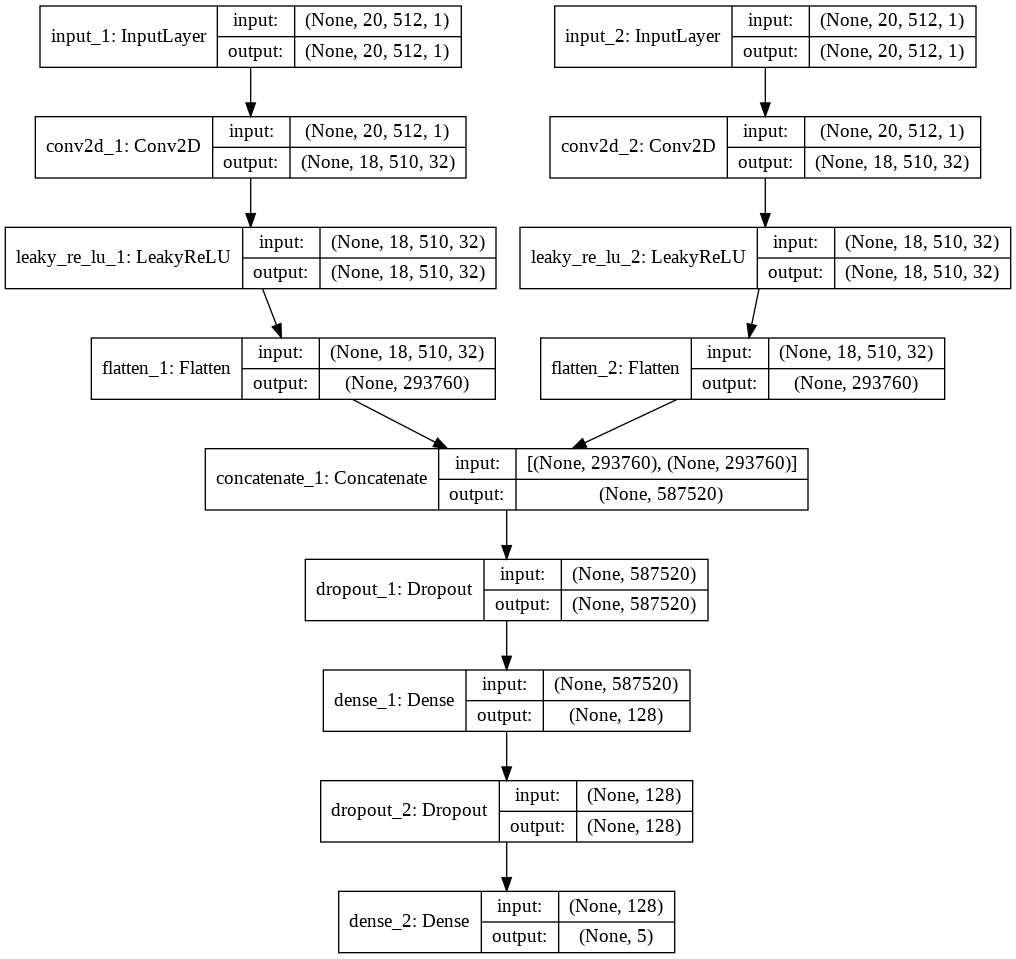

In [ ]:
import keras
from keras.models import Sequential,Model
import keras.layers as ly
from keras.utils import to_categorical,plot_model
from keras import optimizers
# from keras.layers import LeakyReLU


# model.add(Conv2D(..., activation=lrelu, ...)

# input_shape=(feature_dim_1, feature_dim_2, channel)
def get_model(num_classes, input_shape ):
    model = Sequential()
    model.add(ly.Conv2D(32, kernel_size=(3, 3),  input_shape=input_shape))
    model.add(ly.LeakyReLU(alpha=0.1))
    model.add(ly.Conv2D(64, kernel_size=(3, 3)))
    model.add(ly.LeakyReLU(alpha=0.1))
    # model.add(ly.Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(ly.Flatten())
    model.add(ly.Dropout(0.25))## new add
    model.add(ly.Dense(64, activation='relu'))
    model.add(ly.Dropout(0.4))
    model.add(ly.Dense(num_classes, activation='softmax'))
    return model

# def get_model(num_classes, input_shape):
#     model = Sequential()
#     model.add(ly.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
#     model.add(ly.Conv2D(64, kernel_size=(3, 3), activation='relu'))
#     model.add(ly.MaxPooling2D(pool_size=(2, 2)))
#     model.add(ly.Dropout(0.25))
#     model.add(ly.Flatten())
#     model.add(ly.Dense(512, activation='relu')) ## new add
#     model.add(ly.Dropout(0.25))relu## new add
#     model.add(LSTM(128))
#     model.add(Dense(128, activation='relu'))
#     model.add(Dropout(0.25))
#     model.add(ly.Dense(64, activation='relu'))
#     model.add(ly.Dropout(0.4))
#     model.add(ly.Dense(num_classes, activation='softmax'))
#     return model

def get_model_two(num_classes, input_shape1,input_shape2 ):
    inputA = ly.Input(shape=input_shape1)
    inputB = ly.Input(shape=input_shape2)
    x1 = ly.Conv2D(32, kernel_size=(3, 3))(inputA)
    x1 = ly.LeakyReLU(alpha=0.1)(x1)
    # x1 = ly.Conv2D(64, kernel_size=(3, 3))(x1)
    # x1 = ly.LeakyReLU(alpha=0.1)(x1)
    x1 = ly.Flatten()(x1)

    x2 = ly.Conv2D(32, kernel_size=(3, 3))(inputB)
    x2 = ly.LeakyReLU(alpha=0.1)(x2)
    # x2 = ly.Conv2D(64, kernel_size=(3, 3))(x2)
    # x2 = ly.LeakyReLU(alpha=0.1)(x2)
    x2 = ly.Flatten()(x2)

    combined = ly.Concatenate()([x1, x2])
    # z = ly.Dropout(0.25)(x1)
    z = ly.Dropout(0.25)(combined)
    z = ly.Dense(128, activation="relu")(z)
    z = ly.Dropout(0.4)(z)
    z = ly.Dense(num_classes, activation="softmax")(z)
    model = Model(inputs=[inputA, inputB], outputs=[z ])
    # model = Model(inputs=inputA, outputs=z)
    model.summary()
    return model

aaaa= get_model_two(5, (20,512,1), (20,512,1))
plot_model(aaaa,show_shapes=True)

2020-07-16 08:38:07


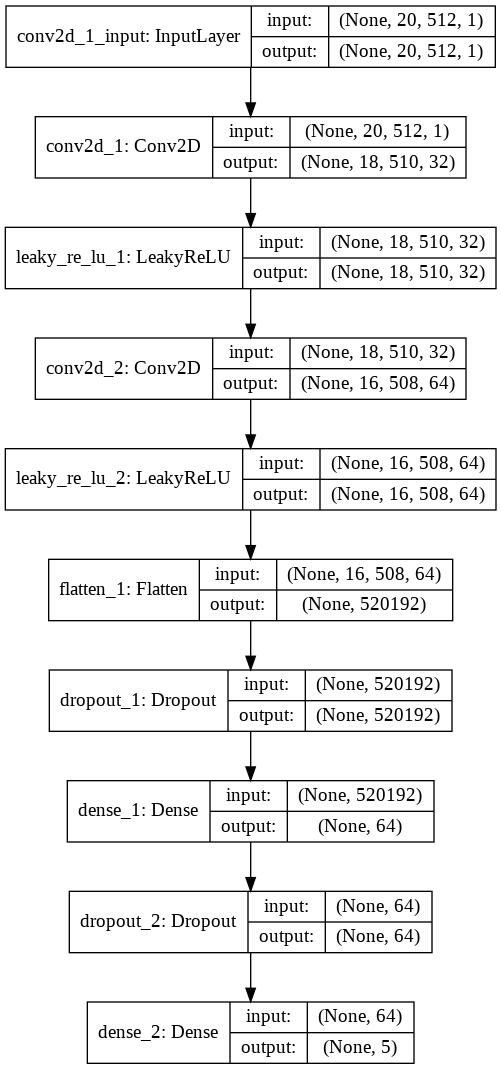

In [ ]:
import time
from tensorflow.keras.callbacks import *

print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))

channel = 1
epochs = 200
batch_size = 128
verbose = 1
keras.backend.clear_session()
num_classes = y_train.shape[1]
input_shape = x_train[0].shape
# input_shape1 = x_train1[0].shape
# input_shape2 = x_train2[0].shape
# input_shape = x_test.shape

# input_shape = (30,MFCC_MAX_LEN,1 )
model = get_model(5, input_shape)
# model = get_model_LSTM(num_classes, input_shape)
# model = get_model_two(num_classes, input_shape1,input_shape2)
plot_model(model, to_file='/content/drive/My Drive/mode.png',show_shapes=True)



In [ ]:
# optimizer = optimizers.SGD(lr=0.0005, decay=1e-6, momentum=0.9, nesterov=True)
# loss_op = keras.losses.categorical_crossentropy
# optimizer=  keras.optimizers.Adam(learning_rate=0.001)
optimizer=  keras.optimizers.Adamax(learning_rate=0.0005)
# loss_op = keras.losses.binary_crossentropy
loss_op = keras.losses.hinge
model.compile(loss=loss_op,
              optimizer=optimizer,
              metrics=['accuracy'])

callbacks_list = [
  # This callback will interrupt training when we have stopped improving
  keras.callbacks.EarlyStopping(
  # This callback will monitor the validation accuracy of the model
  monitor='val_accuracy',
  # Training will be interrupted when the accuracy
  # has stopped improving for *more* than 1 epochs (i.e. 2 epochs)
  patience=3,
  ),
  # This callback will save the current weights after every epoch
  keras.callbacks.ModelCheckpoint(
  filepath='/content/drive/My Drive/model202000716_16.h5', # Path to the destination model file
  # The two arguments below mean that we will not overwrite the
  # model file unless `val_loss` has improved, which
  # allows us to keep the best model every seen during training.
  monitor='val_loss',
  save_best_only=True,
  )
]

# 開始計算

In [ ]:
# history= model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,verbose=verbose, validation_data=(x_test1, x_test2))
history= model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,verbose=verbose, validation_data=(x_test1, y_test1),callbacks=callbacks_list)
# history= model.fit([x_train1,x_train2], y_train, batch_size=batch_size, epochs=epochs,verbose=verbose, validation_data=([x_test1, x_test2],y_test))

Train on 11400 samples, validate on 550 samples
Epoch 1/200
11400/11400 [==============================] - 21s 2ms/step - loss: 1.1135 - accuracy: 0.2160 - val_loss: 1.1120 - val_accuracy: 0.2200
Epoch 2/200
11400/11400 [==============================] - 20s 2ms/step - loss: 1.0971 - accuracy: 0.2577 - val_loss: 1.0784 - val_accuracy: 0.3036
Epoch 3/200
11400/11400 [==============================] - 20s 2ms/step - loss: 1.0921 - accuracy: 0.2696 - val_loss: 1.0649 - val_accuracy: 0.3364
Epoch 4/200
11400/11400 [==============================] - 20s 2ms/step - loss: 1.0777 - accuracy: 0.3054 - val_loss: 1.0618 - val_accuracy: 0.3455
Epoch 5/200
11400/11400 [==============================] - 20s 2ms/step - loss: 1.0637 - accuracy: 0.3410 - val_loss: 1.0445 - val_accuracy: 0.3891
Epoch 6/200
11400/11400 [==============================] - 20s 2ms/step - loss: 1.0580 - accuracy: 0.3546 - val_loss: 1.0651 - val_accuracy: 0.3382
Epoch 7/200
11400/11400 [==============================] - 20s 2

# 儲存model

In [ ]:
from keras.models import load_model

model.save('/content/drive/My Drive/model202000716_1544.h5')  # creates a HDF5 file 'model.h5'

# 練習結果驗證


2020-07-16 08:45:29


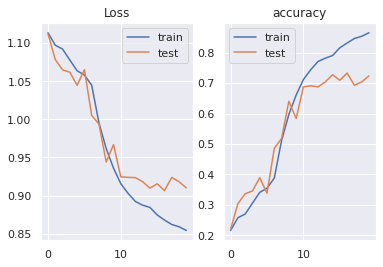

<Figure size 2160x4320 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import time
 
# 格式化成2016-03-20 11:45:39形式

print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
plt.subplot(121)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')

plt.legend()
# plot mse during training
plt.subplot(122)
plt.title('accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')

plt.legend()
plt.figure(figsize=(30,60))
plt.show()

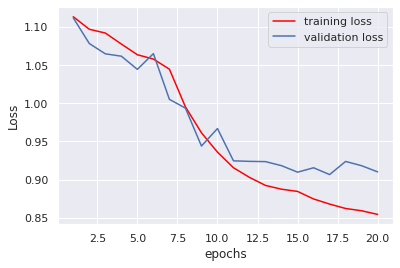

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs=range(1,len(loss)+1)
plt.plot(epochs,loss,'b',label="training loss",c="red")
plt.plot(epochs,val_loss,'b',label="validation loss")
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


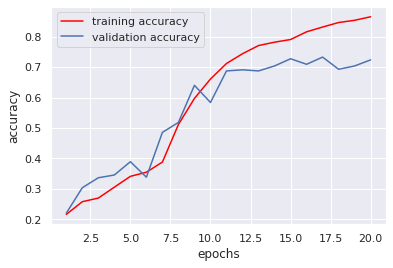

In [ ]:
import matplotlib.pyplot as plt
categorical_accuracy = history.history['accuracy']
val_categorical_accuracy = history.history['val_accuracy']
epochs=range(1,len(categorical_accuracy)+1)
plt.plot(epochs, categorical_accuracy,'b',label="training accuracy",c="red")
plt.plot(epochs, val_categorical_accuracy,'b',label="validation accuracy")
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

# 資料測試驗證

In [ ]:
# loss, accuracy = model.evaluate(x_train, y_train, batch_size=y_test.shape[0], 
#             verbose=False)

loss, accuracy = model.evaluate(x_test, y_test, batch_size=y_test.shape[0], 
            verbose=False)

# loss, accuracy = model.evaluate(y_test1, y_test2, batch_size=y_test.shape[0], 
#             verbose=False)
# Y_testnas = model.predict(x_test)
print("test loss: {}  test accuracy: {}".format(loss,accuracy))

# around1 = np.around(Y_testnas).astype(np.int)
# around1

test loss: 0.2576535642147064  test accuracy: 0.8996363282203674


In [ ]:
# x_train,y_train =  GetFataFromNp(x_train_o,y_train_o ,add_size=10)
x_test,y_test =  GetFataFromNp(x_test_o,y_test_o ,add_size=30)

now in 0 / 100====>there are 0 data


(1100,)
(1100,)


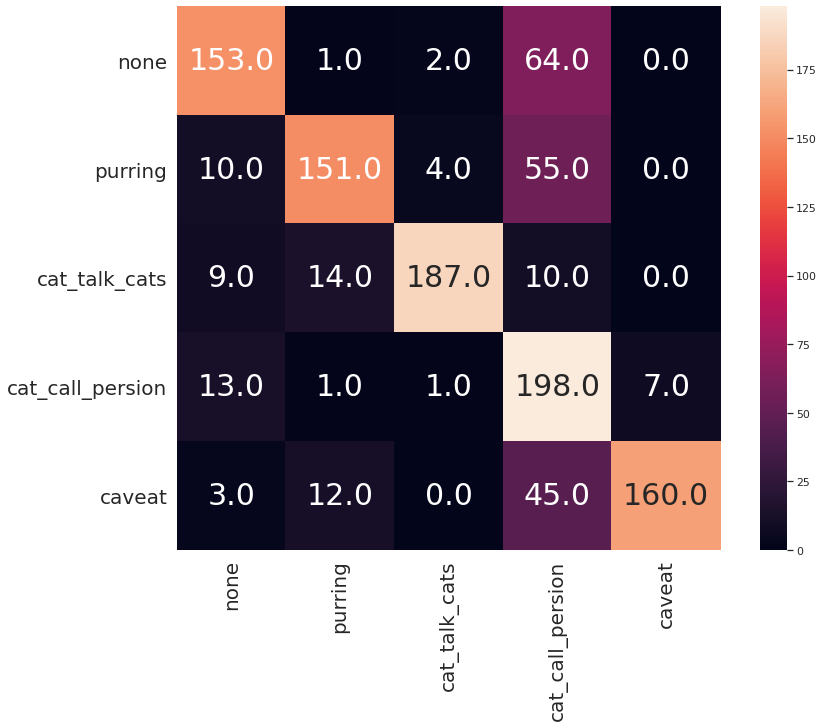

In [ ]:
from sklearn.metrics import confusion_matrix 
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns; 
from sklearn.metrics import confusion_matrix 
sns.set()

y_true =np.argmax(y_test, axis=1)
# y_true =np.argmax(y_train, axis=1)
list_sigle =['none', 'purring', 'cat_talk_cats', 'cat_call_persion', 'caveat']
y_pred = model.predict(x_test)
# y_pred = model.predict(x_train)
y_pred =np.argmax(y_pred, axis=1)
# plt.xticks(fontsize=20)
# plt.yticks(fontsize=20)
fig, ax= plt.subplots(figsize = (14, 10),)

# ax.set_xticklabels(x_ticks, rotation=0, fontsize=8)
# ax.set_yticklabels(y_ticks, rotation=0, fontsize=8)
# sns.set(font_scale=5) 
print(y_true.shape)
print(y_pred.shape)
y_true =[list_sigle[x] for x in y_true ]
y_pred =[list_sigle[x] for x in y_pred ]
C=confusion_matrix(y_true, y_pred)
# ax.set_xticklabels(x_ticks, rotation=0, fontsize=8)
# ax.set_yticklabels(y_ticks, rotation=0, fontsize=8)
# ax.set_xticklabels(list_sigle, rotation=0, fontsize=30)
# ax.set_yticklabels(list_sigle, rotation=0, fontsize=30)
ax.set_xticklabels(list_sigle,rotation=0,fontsize=20)
ax.set_yticklabels(list_sigle,rotation=0,fontsize=20)
# pd.crosstab(y_test ,y_pred, rownames=['實際值'], colnames=['預測值'])
# print(C)
# sns.heatmap.set_xticklabels(fontsize=30)
# sns.heatmap.set_yticklabels(fontsize=30)
sns.heatmap(C,annot=True, annot_kws={"size": 30},square=True ,fmt ='.1f',xticklabels =list_sigle, yticklabels =list_sigle,ax=ax)
# sns.heatmap(C,annot=True, annot_kws={"size": 30},square=True ,fmt ='.1f',ax=ax)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


<Figure size 432x288 with 0 Axes>

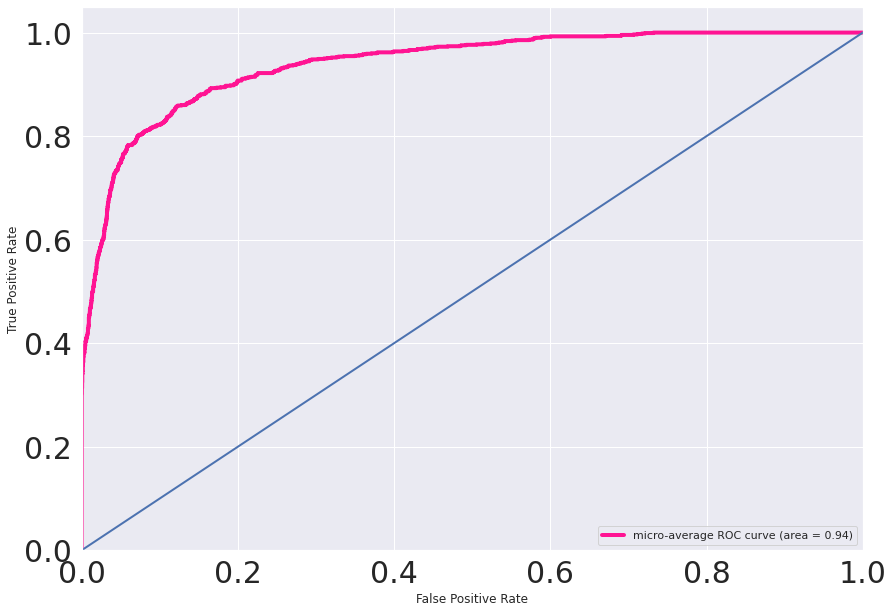

In [ ]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle
fpr = dict() 
tpr = dict() 
roc_auc = dict() 
y_score = model.predict(x_test)
for i in range(5): 
  fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i]) 
  roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel()) 
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(5)])) 
# Then interpolate all ROC curves at this points 
mean_tpr = np.zeros_like(all_fpr) 
for i in range(5): 
  mean_tpr += interp(all_fpr, fpr[i], tpr[i]) 
# Finally average it and compute AUC 
mean_tpr /= 5 
fpr["macro"] = all_fpr 
tpr["macro"] = mean_tpr 
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])


lw=2 

plt.figure() 
plt.subplots(figsize = (14, 10))
plt.plot(fpr["micro"], tpr["micro"], label='micro-average ROC curve (area = {0:0.2f})' ''.format(roc_auc["micro"]), color='deeppink', linestyle='-', linewidth=4)
# plt.plot(fpr["macro"], tpr["macro"], label='macro-average ROC curve (area = {0:0.2f})' ''.format(roc_auc["macro"]), color='navy', linestyle=':', linewidth=4) 
colors = cycle(['aqua', 'darkorange', 'cornflowerblue']) 
# for i, color in zip(range(5), colors): 
#   plt.plot(fpr[i], tpr[i], color=color, lw=lw, label='ROC curve of class {0} (area = {1:0.2f})' ''.format(i, roc_auc[i])) 
plt.plot([0, 1], [0, 1], '-', lw=lw) 
plt.xlim([0.0, 1.0]) 
plt.ylim([0.0, 1.05]) 
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
# plt.title('Some extension of Receiver operating characteristic to multi-class') 
plt.legend(loc="lower right") 
# plt.figsize(14, 10)
# plt.set_size_inches(18.5, 10.5)
plt.show()


In [ ]:
# 
def plot_confusion_matrix(cm, labels_name, title):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]    # 归一化
    plt.imshow(cm, interpolation='nearest')    # 在特定的窗口上显示图像
    plt.title(title)    # 图像标题
    plt.colorbar()
    num_local = np.array(range(len(labels_name)))    
    plt.xticks(num_local, labels_name, rotation=90)    # 将标签印在x轴坐标上
    plt.yticks(num_local, labels_name)    # 将标签印在y轴坐标上
    plt.ylabel('True label')    
    plt.xlabel('Predicted label')


plot_confusion_matrix(C, list_sigle, "HAR Confusion Matrix")
plt.show

In [ ]:
print(C)

[[57  0  2 16  5]
 [12 49 10  4  5]
 [13  1 53  6  7]
 [24  0  1 51  4]
 [ 1  1  7 10 61]]


In [ ]:
from pydub import AudioSegment
import os
import numpy as np
import scipy.io.wavfile as wav
import random
import librosa
from sklearn.model_selection import train_test_split
import gc
# SAMPLING_RATE = 44100
MFCC_NUM = 20
MFCC_MAX_LEN = 512
SAMPLING_RATE=22050
# def wav2mfcc(wave, max_len=2000):
# #     mfcc = librosa.feature.mfcc(wave, sr=16000)
#     wave = wave / np.amax(wave)
#     mfcc = librosa.feature.mfcc(wave, n_mfcc=MFCC_NUM, sr=SAMPLING_RATE)

#     # If maximum length exceeds mfcc lengths then pad the remaining ones
#     if (max_len > mfcc.shape[1]):
#         pad_width = max_len - mfcc.shape[1]
#         mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')

#     # Else cutoff the remaining parts
#     else:
#         mfcc = mfcc[:, :max_len]
    
#     return mfcc

def wav2mfcc(wave, max_len=512):
#     mfcc = librosa.feature.mfcc(wave, sr=16000)
    wave_mean = abs(np.mean(wave))
    
    if wave_mean != 0:
      wave = wave / wave_mean
    mfcc = librosa.feature.mfcc(wave, n_mfcc=MFCC_NUM, sr=SAMPLING_RATE)

    # If maximum length exceeds mfcc lengths then pad the remaining ones
    if (max_len > mfcc.shape[1]):
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')

    # Else cutoff the remaining parts
    else:
        mfcc = mfcc[:, :max_len]
    
    return mfcc



def create_test_data(path="F:/catsound/excmple", extension = "wav"):
#     wave, sr = librosa.load(path, mono=True, sr=None)
    mfcc_list = []
    audio, sr = librosa.load(path, mono=True, sr=None)
# Get number of samples for 2 seconds; replace 2 by any number
    buffer = 2 * sr
    samples_total = len(audio)
    samples_wrote = 0
    counter = 1
    while samples_wrote < samples_total:
        #check if the buffer is not exceeding total samples 
        if buffer > (samples_total - samples_wrote):
            buffer = samples_total - samples_wrote
        block = audio[samples_wrote : (samples_wrote + buffer)]
        mfcc = wav2mfcc(block,MFCC_MAX_LEN)
        
        mfcc_list.append(mfcc)
        counter += 1
        samples_wrote += buffer
    mfcc_list = np.array(mfcc_list)
    mfcc_list = mfcc_list.reshape(mfcc_list.shape[0], MFCC_NUM, MFCC_MAX_LEN, 1)
    return mfcc_list


def create_test_data2(path="F:/catsound/excmple", extension = "wav"):
#     wave, sr = librosa.load(path, mono=True, sr=None)
    mfcc_list = []
    audio, sr = librosa.load(path, mono=True, sr=None)
# Get number of samples for 2 seconds; replace 2 by any number
    buffer = 2 * sr
    samples_total = len(audio)
    samples_wrote = 0
    counter = 1
    while samples_wrote < samples_total:
        #check if the buffer is not exceeding total samples 
        if buffer > (samples_total - samples_wrote):
            buffer = samples_total - samples_wrote
        block = audio[samples_wrote : (samples_wrote + buffer)]
        data = np.append(wav2mfcc(wave),wav2stft(wave),axis=0)
        data_list.append(data)
        counter += 1
        samples_wrote += buffer
    data_list = np.array(mfcc_list)
    data_list = data_list.reshape(data_list.shape[0], data_list.shape[1], data_list.shape[2], 1)
    return mfcc_list


def test_ans_show(path,model, extension = "wav" ):
  list_sigle =['none', 'purring', 'cat_talk_cats', 'cat_call_persion', 'caveat']

  test_one_list = create_test_data(path)
  Y_testnas = model.predict(test_one_list)

  Y_testnas = Y_testnas[~np.all(Y_testnas < 0.1, axis=1)]
  Y_testnas = np.mean(Y_testnas, axis = 0)
  Y_testnas = np.around(Y_testnas, decimals=2) 


  ans = {}
  for i in range(len(list_sigle)):
    ans[list_sigle[i]] = Y_testnas[i]
  print(ans)


# test_one_list = create_test_data("F:/python_coding/sound/wavfile/cut_angry/cat_angry (876).wav")
# test_one_list = create_test_data("/content/drive/My Drive/貓打架-專業版.wav")
# for i in test_one_list:
#     ipd.Audio(i)

# 讀取madel

In [ ]:
from keras.models import load_model

model = load_model('/content/drive/My Drive/model20200627_leakyRelu_1.h5')  # creates a HDF5 file 'model.h5'
# model = load_model('/content/drive/My Drive/model202000716_16.h5')  # creates a HDF5 file 'model.h5'


Using TensorFlow backend.


In [ ]:

# test_one_list = create_test_data("/content/drive/My Drive/貓打架-專業版.wav")
# Y_testnas = model.predict(test_one_list)
# around1 = np.around(Y_testnas)
# around1
# list_sigle =['none', 'purring', 'cat_talk_cats', 'cat_call_persion', 'caveat']

test_path = "/content/drive/My Drive/test_sound/"
wav_test_list = os.listdir(test_path)
for name in wav_test_list:
    print( name )
    test_ans_show( f"{test_path}/{name}" , model)


小貓發情了！碎花要變少女了嗎丨麻糬貓奴貓咪日常 001.wav
{'none': 0.05, 'purring': 0.04, 'cat_talk_cats': 0.27, 'cat_call_persion': 0.04, 'caveat': 0.59}
来听猫叔打呼噜吧, 非常的治愈哦 标清.wav
{'none': 0.33, 'purring': 0.11, 'cat_talk_cats': 0.12, 'cat_call_persion': 0.33, 'caveat': 0.11}
貓打架-專業版.wav
{'none': 0.0, 'purring': 0.0, 'cat_talk_cats': 1.0, 'cat_call_persion': 0.0, 'caveat': 0.0}
貓(喵)老大打架_.wav
{'none': 0.07, 'purring': 0.03, 'cat_talk_cats': 0.04, 'cat_call_persion': 0.15, 'caveat': 0.71}
噓聲.wav
{'none': 0.0, 'purring': 0.0, 'cat_talk_cats': 1.0, 'cat_call_persion': 0.0, 'caveat': 0.0}
风声_爱给网_aigei_com.wav
{'none': 0.33, 'purring': 0.12, 'cat_talk_cats': 0.2, 'cat_call_persion': 0.23, 'caveat': 0.12}
只想宅在家｜碧昂絲專屬教練教妳結合皮拉提斯和芭蕾的健身 - Barre，全身都能瘦！｜Stay Home With ELLE.wav
{'none': 0.16, 'purring': 0.25, 'cat_talk_cats': 0.2, 'cat_call_persion': 0.14, 'caveat': 0.25}
Cat asking for help.wav
{'none': 0.06, 'purring': 0.22, 'cat_talk_cats': 0.48, 'cat_call_persion': 0.05, 'caveat': 0.19}
Cat Purring Sound Effect!.wav
{'non

# list_sigle =['none', 'purring', 'cat_talk_cats', 'cat_call_persion', 'caveat']
